In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import torch.nn as nn

In [2]:
device = torch.device('cpu')

In [6]:
num_epochs = 5
num_classes = 40
learning_rate = 0.001
batch_size=8

0 torch.Size([8, 3, 112, 92])
1 torch.Size([8, 3, 112, 92])
2 torch.Size([8, 3, 112, 92])
3 torch.Size([8, 3, 112, 92])


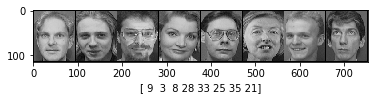

In [13]:
dataset = datasets.ImageFolder(root='faces/', transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=4)
for i, batch in enumerate(train_loader):
    print(i, batch[0].size())
    if i==3:
        grid=utils.make_grid(batch[0])
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.xlabel(batch[1].numpy())
        plt.show()
        break

In [14]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=40):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU())
        self.fc = nn.Linear(56 * 46 * 24, out_features=num_classes)        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(-1, 56 * 46 * 24)
        out = self.fc(out)
        return out

In [15]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % batch_size == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [8/40], Loss: 24.8093
Epoch [1/5], Step [16/40], Loss: 30.6989
Epoch [1/5], Step [24/40], Loss: 5.8900
Epoch [1/5], Step [32/40], Loss: 6.3221
Epoch [1/5], Step [40/40], Loss: 2.5573
Epoch [2/5], Step [8/40], Loss: 5.1205
Epoch [2/5], Step [16/40], Loss: 1.5082
Epoch [2/5], Step [24/40], Loss: 0.8283
Epoch [2/5], Step [32/40], Loss: 0.5720
Epoch [2/5], Step [40/40], Loss: 0.0875
Epoch [3/5], Step [8/40], Loss: 0.0111
Epoch [3/5], Step [16/40], Loss: 0.9955
Epoch [3/5], Step [24/40], Loss: 0.0555
Epoch [3/5], Step [32/40], Loss: 0.0112
Epoch [3/5], Step [40/40], Loss: 0.0000
Epoch [4/5], Step [8/40], Loss: 1.5353
Epoch [4/5], Step [16/40], Loss: 0.0000
Epoch [4/5], Step [24/40], Loss: 0.0000
Epoch [4/5], Step [32/40], Loss: 0.1901
Epoch [4/5], Step [40/40], Loss: 0.0000
Epoch [5/5], Step [8/40], Loss: 0.0000
Epoch [5/5], Step [16/40], Loss: 0.0000
Epoch [5/5], Step [24/40], Loss: 0.0000
Epoch [5/5], Step [32/40], Loss: 0.0000
Epoch [5/5], Step [40/40], Loss: 0.0000


In [22]:
test_set = datasets.ImageFolder(root='test_faces/', transform=transforms.ToTensor() )
test_loader = DataLoader(test_set, batch_size=4,shuffle=True)

In [32]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test accuracy of the model on the test set: {} %' .format(100*correct/total))

Test accuracy of the model on the test set: 95.0 %


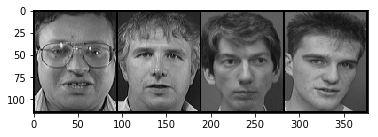

Labels: tensor([ 24,   6,  21,  23])
Predicted: tensor([ 24,   6,  21,  23])


In [35]:
grid=utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()
print('Labels:', labels) 
print('Predicted:', predicted)

In [34]:
torch.save(model.state_dict(), 'model.ckpt')